In [20]:
!pip install torch torchvision matplotlib opencv-python


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import glob
# from torchvision import transforms
import numpy as np
import cv2


In [2]:
train_path = "train/images"
labels_path = "train/labels"

Jumlah gambar: 1900


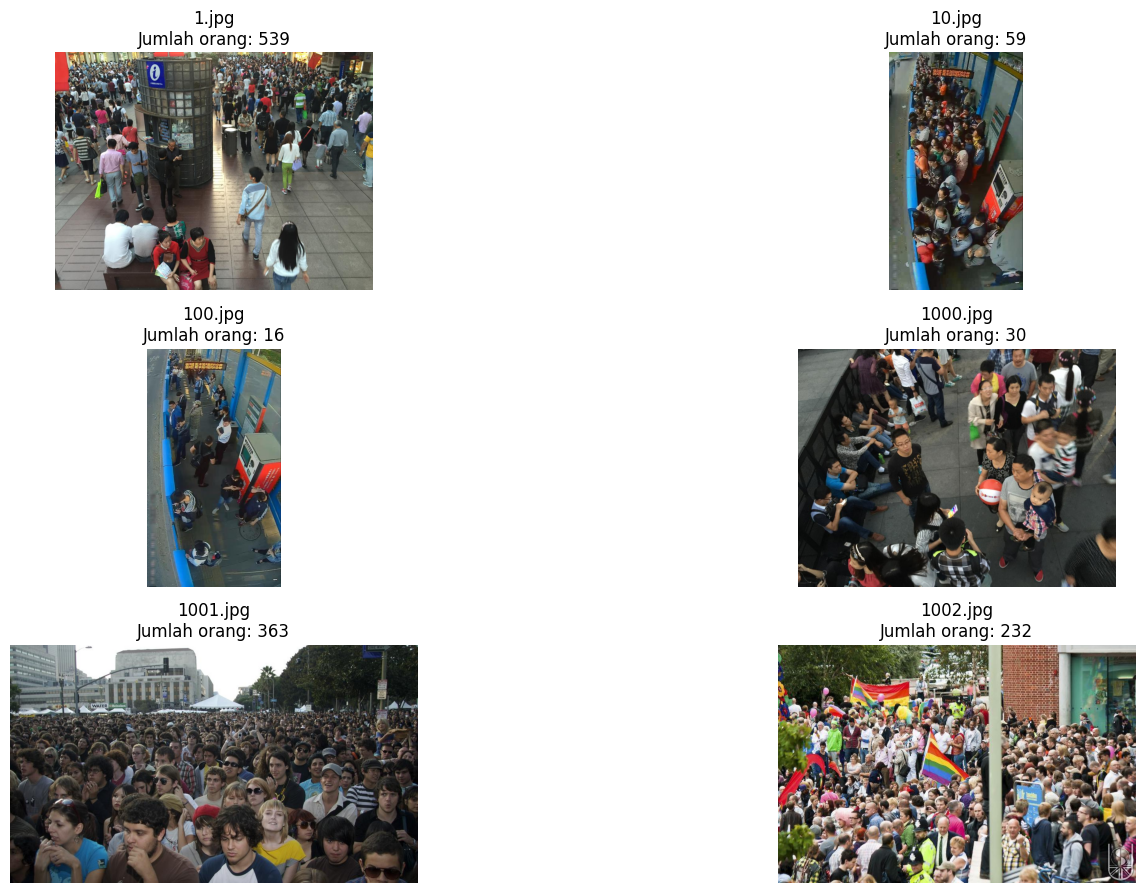

In [4]:
import os
from PIL import Image
import json

import matplotlib.pyplot as plt

image_files = sorted(os.listdir(train_path))  # sorting
n_images = len(image_files)
print(f"Jumlah gambar: {n_images}")

# limit display
limit = 6
selected_files = image_files[:limit]

# Tampilkan dalam grid
cols = 2
rows = (len(selected_files) // cols) + 1
plt.figure(figsize=(15, rows * 3))

for i, file in enumerate(selected_files):
    img_path = os.path.join(train_path, file)
    img = Image.open(img_path)

    # read json for the current image
    label_file = os.path.join(labels_path, file.replace(".jpg", ".json"))
    count = 0  # Initialize count
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            data = json.load(f)
        # hitung jumlah orang
        count = len(data["points"])

    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{file}\nJumlah orang: {count}")

plt.tight_layout()
plt.show()

Data transformations defined successfully!

Transformations include:
- Resize to 224x224
- Random horizontal flip (training only)
- Random crop with scale 0.8-1.0 (training only)
- Color jitter: brightness ±20%, contrast ±20% (training only)
- Tensor conversion and ImageNet normalization

Demonstrating transformations on: 1.jpg
Original image size: (1024, 768)
Transformed tensor shape: torch.Size([3, 224, 224])


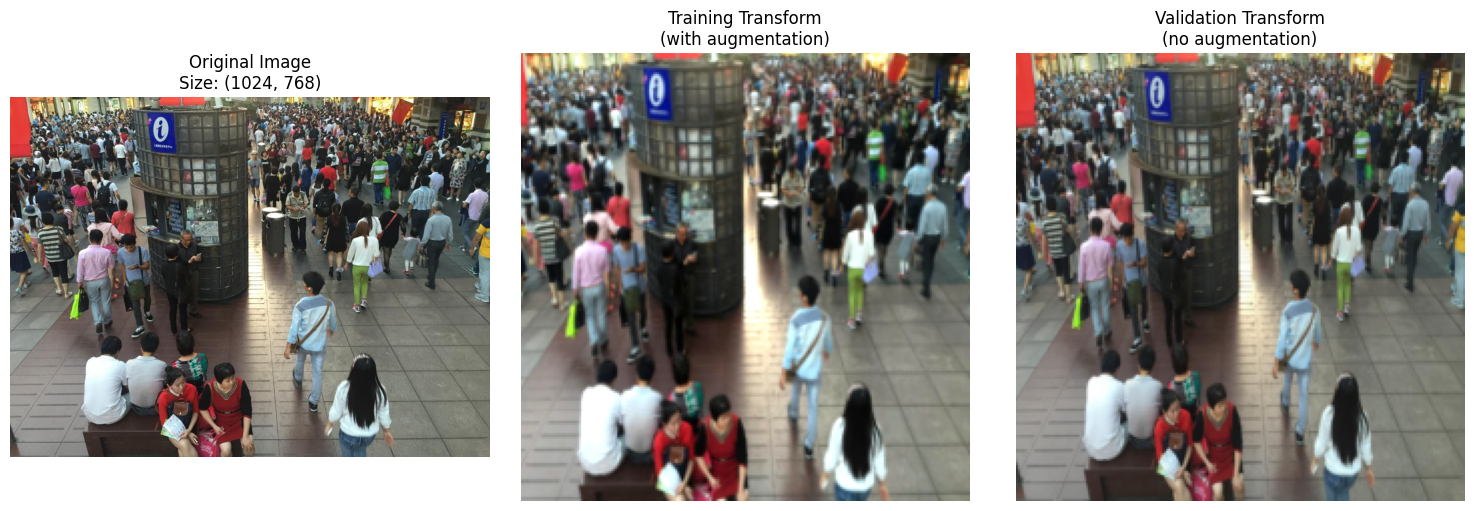

In [24]:
import torch
from torchvision import transforms


# ==============================================================================
# SECTION: DATASET TRANSFORMATIONS
# ==============================================================================

# Define comprehensive image transformations
data_transforms = {
    'train': transforms.Compose([
        # Resize to a standard size
        transforms.Resize((224,224)),
        
        # Random horizontal flip for data augmentation
        transforms.RandomHorizontalFlip(p=0.5),
        
        # Random crop (with padding if needed)
        transforms.RandomResizedCrop(size=(224,224), scale=(0.8, 1.0), ratio=(0.8, 1.2)),
        
        # Color jitter for brightness and contrast
        transforms.ColorJitter(
            brightness=0.2,  # Random brightness adjustment
            contrast=0.2,    # Random contrast adjustment
            saturation=0.1,  # Slight saturation adjustment
            hue=0.05         # Slight hue adjustment
        ),
        
        # Convert to tensor and normalize
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        # For validation, only resize and normalize (no augmentation)
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        # Same as validation
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

print("Data transformations defined successfully!")
print("\nTransformations include:")
print("- Resize to 224x224")
print("- Random horizontal flip (training only)")
print("- Random crop with scale 0.8-1.0 (training only)")
print("- Color jitter: brightness ±20%, contrast ±20% (training only)")
print("- Tensor conversion and ImageNet normalization")

# Demonstration with a sample image
if image_files:
    sample_img_filename = image_files[0]
    sample_img_path = os.path.join(train_path, sample_img_filename)
    sample_img = Image.open(sample_img_path).convert('RGB')
    
    print(f"\nDemonstrating transformations on: {sample_img_filename}")
    print(f"Original image size: {sample_img.size}")
    
    # Apply transformations
    train_transformed = data_transforms['train'](sample_img)
    val_transformed = data_transforms['val'](sample_img)
    
    print(f"Transformed tensor shape: {train_transformed.shape}")
    
    # Visualize the effects
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img)
    plt.title(f"Original Image\nSize: {sample_img.size}")
    plt.axis('off')
    
    # Training transformation (denormalize for display)
    plt.subplot(1, 3, 2)
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    train_denorm = train_transformed * std + mean
    train_denorm = torch.clamp(train_denorm, 0, 1)
    plt.imshow(train_denorm.permute(1, 2, 0))
    plt.title("Training Transform\n(with augmentation)")
    plt.axis('off')
    
    # Validation transformation (denormalize for display)
    plt.subplot(1, 3, 3)
    val_denorm = val_transformed * std + mean
    val_denorm = torch.clamp(val_denorm, 0, 1)
    plt.imshow(val_denorm.permute(1, 2, 0))
    plt.title("Validation Transform\n(no augmentation)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

#CSRNet Progress


Generated density map for transformed 1.jpg
Original image size: (1024, 768)
Transformed image size: torch.Size([3, 224, 224])
Density map shape: (224, 224)
Number of valid points: 539
Density map sum: 535.87


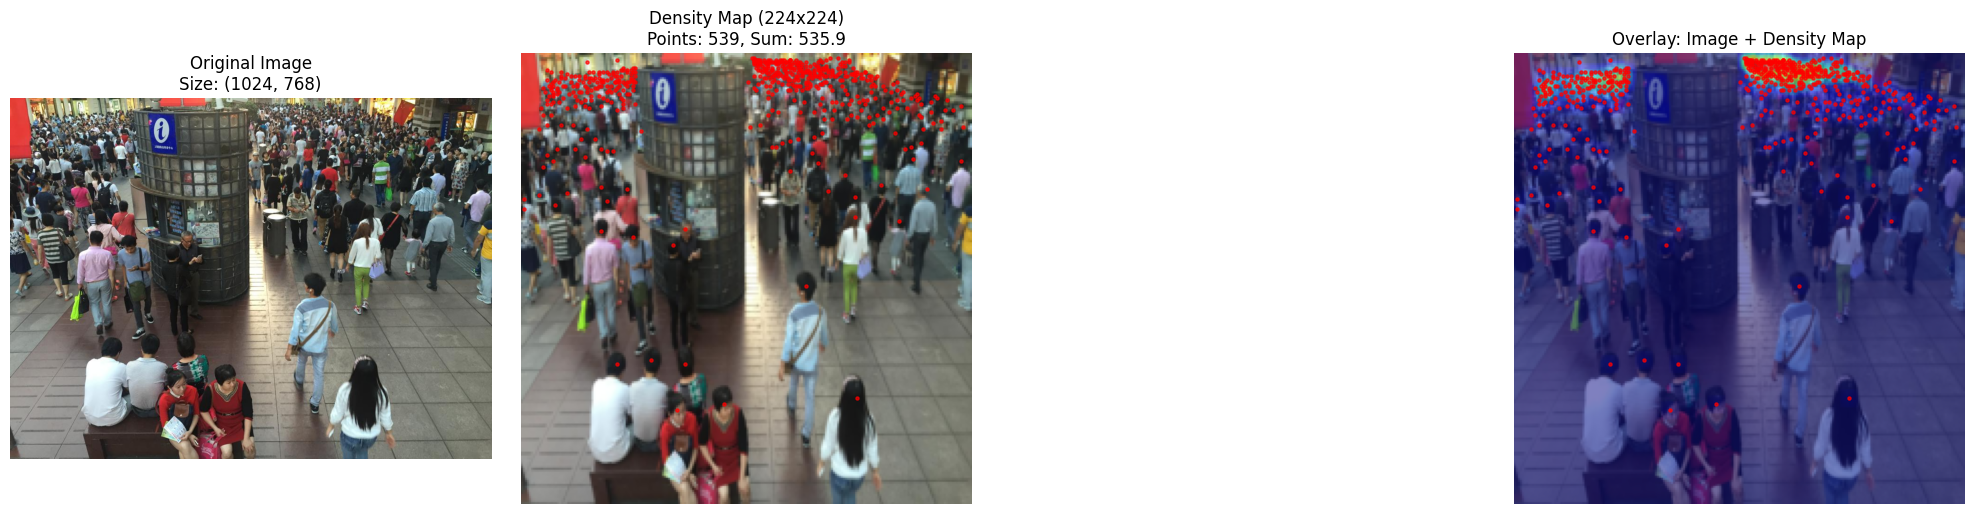

In [25]:
import cv2
import numpy as np
import os
import json

import matplotlib.pyplot as plt

# Improve the density map generation to work with transformed data
def generate_density_map_for_transformed(image_path, label_path, target_size=(224, 224), sigma=4):
    """
    Generate density map for transformed images (resized to 224x224)
    """
    # Read original image to get annotation points
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image at {image_path}")
        return None, []

    original_height, original_width = img.shape[:2]
    
    # Create density map for target size
    target_height, target_width = target_size
    density_map = np.zeros((target_height, target_width), dtype=np.float32)

    if not os.path.exists(label_path):
        print(f"Warning: Label file not found at {label_path}")
        return density_map, []

    with open(label_path, "r") as f:
        label_data = json.load(f)

    points = label_data.get("points", [])
    valid_points = []

    # Calculate scaling factors
    scale_x = target_width / original_width
    scale_y = target_height / original_height

    for point in points:
        if isinstance(point, (list, tuple)) and len(point) >= 2:
            x, y = int(point[0]), int(point[1])
        elif isinstance(point, dict) and 'x' in point and 'y' in point:
            x, y = int(point['x']), int(point['y'])
        else:
            continue

        # Scale coordinates to target size
        x_scaled = int(x * scale_x)
        y_scaled = int(y * scale_y)

        if 0 <= x_scaled < target_width and 0 <= y_scaled < target_height:
            valid_points.append((x_scaled, y_scaled))
            
            # Create Gaussian kernel
            kernel_size = 2 * sigma + 1
            gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
            gaussian_kernel = gaussian_kernel @ gaussian_kernel.T
            
            # Determine region to place the kernel
            x_start = max(0, x_scaled - sigma)
            y_start = max(0, y_scaled - sigma)
            x_end = min(target_width, x_scaled + sigma + 1)
            y_end = min(target_height, y_scaled + sigma + 1)
            
            # Corresponding kernel region
            kx_start = x_start - (x_scaled - sigma)
            ky_start = y_start - (y_scaled - sigma)
            kx_end = kx_start + (x_end - x_start)
            ky_end = ky_start + (y_end - y_start)
            
            # Add the kernel to density map
            density_map[y_start:y_end, x_start:x_end] += gaussian_kernel[ky_start:ky_end, kx_start:kx_end]

    return density_map, valid_points

# Generate density map for the already loaded sample image using existing variables
density_map_224, valid_points_224 = generate_density_map_for_transformed(
    sample_img_path, 
    sample_img_path.replace('images', 'labels').replace('.jpg', '.json'), 
    target_size=(224, 224)
)

if density_map_224 is not None:
    print(f"Generated density map for transformed {sample_img_filename}")
    print(f"Original image size: {sample_img.size}")
    print(f"Transformed image size: {val_transformed.shape}")
    print(f"Density map shape: {density_map_224.shape}")
    print(f"Number of valid points: {len(valid_points_224)}")
    print(f"Density map sum: {density_map_224.sum():.2f}")

    plt.figure(figsize=(20, 5))

    # Original image
    plt.subplot(1, 4, 1)
    plt.imshow(sample_img)
    plt.title(f"Original Image\nSize: {sample_img.size}")
    plt.axis("off")

    # Transformed image (use pre-computed denormalized tensor)
    plt.subplot(1, 4, 2)
    plt.imshow(val_denorm.permute(1, 2, 0))
    plt.title("Transformed Image\n(224x224, no augmentation)")
    plt.axis("off")

    # Density map
    if valid_points_224:
        x_coords = [p[0] for p in valid_points_224]
        y_coords = [p[1] for p in valid_points_224]
        plt.scatter(x_coords, y_coords, color='red', s=5, alpha=0.7)
    plt.title(f"Density Map (224x224)\nPoints: {len(valid_points_224)}, Sum: {density_map_224.sum():.1f}")
    plt.axis("off")

    # Overlay density map on transformed image
    plt.subplot(1, 4, 4)
    plt.imshow(val_denorm.permute(1, 2, 0))
    plt.imshow(density_map_224, cmap='jet', alpha=0.5)
    if valid_points_224:
        plt.scatter(x_coords, y_coords, color='red', s=5, alpha=0.7)
    plt.title("Overlay: Image + Density Map")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("Could not generate density map.")


--- Exporting Density Maps to NPY Files ---
Created directory: density_maps
Processing training images...


Generating density maps: 100%|██████████| 1900/1900 [00:47<00:00, 39.93it/s]


Successfully exported 1900 density maps to 'density_maps' directory

--- Verification: Loading and displaying sample density maps ---


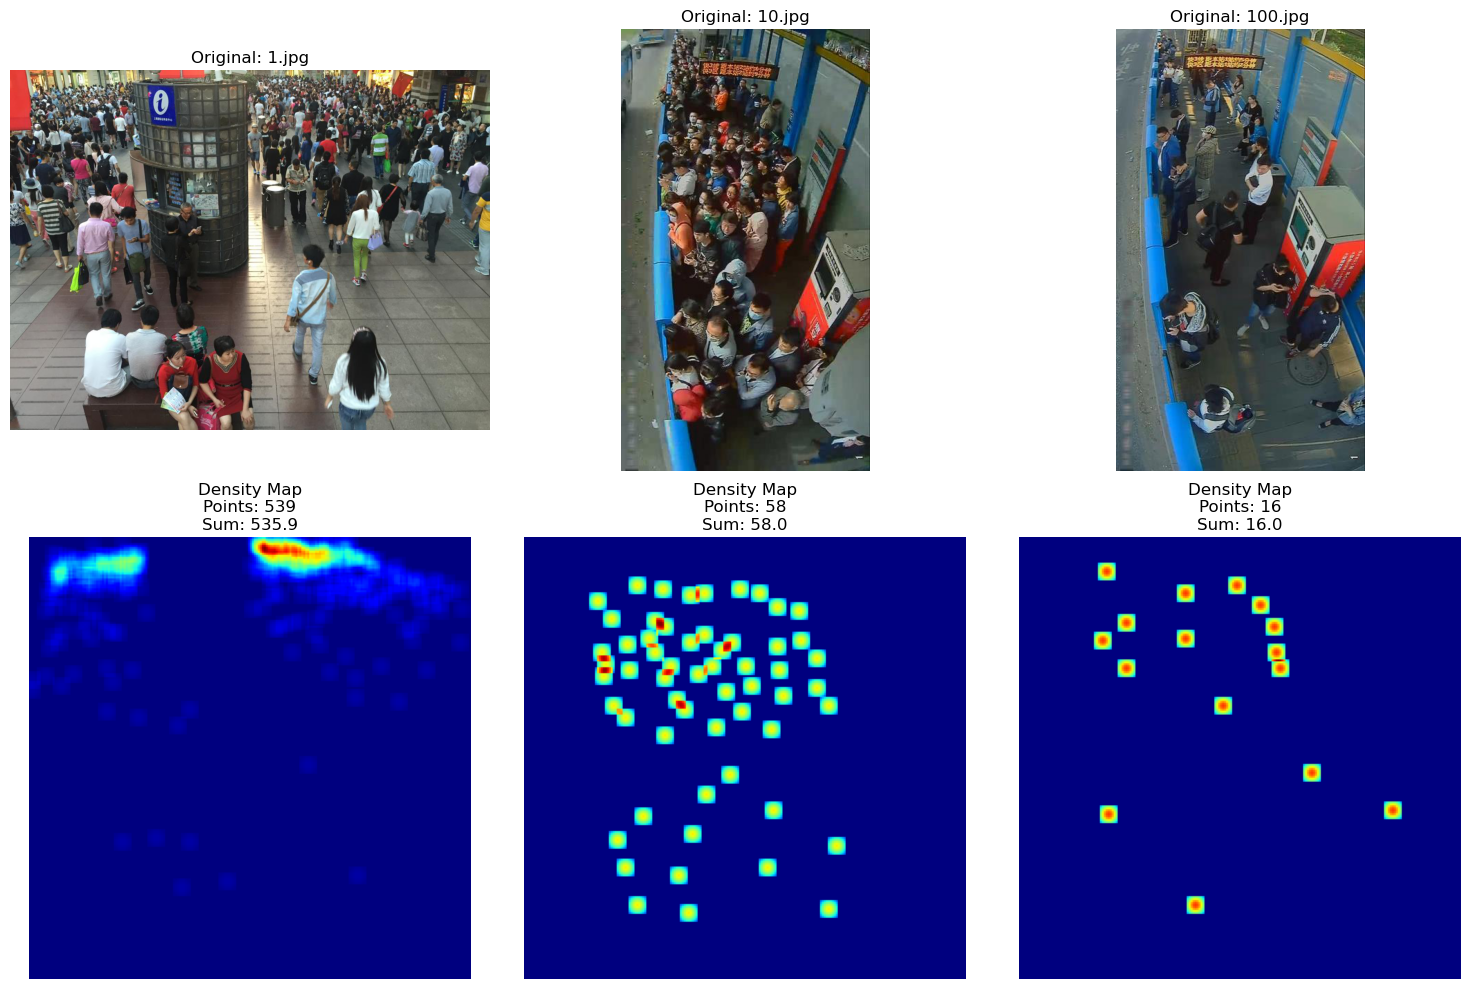


Density maps export complete!
Location: c:\laragon\www\Personal_Learning\Language\Phyton\Data\hology\density_maps
Files created: 3800 (density maps + metadata)


In [ ]:
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import json
import os

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        if load_weights:
            # Load pre-trained VGG-16 weights
            vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            self._initialize_weights()

            # Transfer weights from VGG-16 frontend
            vgg_features = list(vgg.features.state_dict().items())
            csrnet_frontend_state_dict = self.frontend.state_dict()
            csrnet_keys = list(csrnet_frontend_state_dict.keys())

            for i in range(len(vgg_features)):
                if i < len(csrnet_keys):
                    csrnet_frontend_state_dict[csrnet_keys[i]] = vgg_features[i][1]

            self.frontend.load_state_dict(csrnet_frontend_state_dict)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        # Initialize weights for the backend and output layer
        for m in self.backend.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        nn.init.normal_(self.output_layer.weight, std=0.01)
        if self.output_layer.bias is not None:
            nn.init.constant_(self.output_layer.bias, 0)

def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    layers = []
    d_rate = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            # Apply dilation if requested for backend layers
            if dilation:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
                d_rate = 2 # Increase dilation rate for subsequent layers in backend
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1) # Standard convolution for frontend

            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

# Custom Dataset for training with pre-generated density maps
class DensityMapDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform
        
        # Default transform if none provided
        if self.transform is None:
            self.transform = data_transforms['train']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image from file path
        img_filename = self.image_files[idx]
        img_path = os.path.join(train_path, img_filename)
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms to image
        image = self.transform(image)
        
        # Load corresponding label file and generate density map
        label_file = os.path.join(labels_path, img_filename.replace('.jpg', '.json'))
        with open(label_file, 'r') as f:
            label_data = json.load(f)
        
        # Generate density map from points
        points = label_data['points']
        density_map = self._generate_density_map(image.shape[-2:], points)
        
        # Convert to tensor and add channel dimension
        density_map = torch.from_numpy(density_map).unsqueeze(0).float()
        
        # Resize density map to match model output size (1/8 of input)
        # Input is 224x224, so output should be 28x28
        density_map = F.interpolate(density_map.unsqueeze(0), size=(28, 28), mode='bilinear', align_corners=False).squeeze(0)
        
        return image, density_map
    
    def _generate_density_map(self, img_size, points):
        """Generate Gaussian density map from point annotations"""
        h, w = img_size
        density_map = np.zeros((h, w), dtype=np.float32)
        
        if len(points) == 0:
            return density_map
            
        # Convert points to coordinates scaled to image size
        for point in points:
            x = int(point['x'] * w / 1024)  # Scale from original size to current size
            y = int(point['y'] * h / 768)
            
            # Ensure coordinates are within bounds
            if 0 <= x < w and 0 <= y < h:
                # Add Gaussian kernel around each point
                sigma = 3  # Fixed sigma for simplicity
                kernel_size = int(3 * sigma)
                
                x_min = max(0, x - kernel_size)
                x_max = min(w, x + kernel_size + 1)
                y_min = max(0, y - kernel_size)
                y_max = min(h, y + kernel_size + 1)
                
                for i in range(y_min, y_max):
                    for j in range(x_min, x_max):
                        dist_sq = (i - y) ** 2 + (j - x) ** 2
                        density_map[i, j] += np.exp(-dist_sq / (2 * sigma ** 2))
        
        return density_map

# Setup training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = CSRNet(load_weights=True).to(device)
print("CSRNet model initialized with VGG-16 pretrained weights")

# Create dataset splits
train_size = int(0.8 * len(image_files))
val_size = len(image_files) - train_size

train_files = image_files[:train_size]
val_files = image_files[train_size:]

print(f"Training set: {len(train_files)} images")
print(f"Validation set: {len(val_files)} images")

# Create datasets
train_dataset = DensityMapDataset(train_files, data_transforms['train'])
val_dataset = DensityMapDataset(val_files, data_transforms['val'])

# Create dataloaders
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training parameters
num_epochs = 50
best_val_loss = float('inf')

# Training history
train_losses = []
val_losses = []

print("\n" + "="*60)
print("STARTING CSRNET TRAINING")
print("="*60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    for batch_idx, (images, density_maps) in enumerate(tqdm(train_loader, desc="Training")):
        images = images.to(device)
        density_maps = density_maps.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, density_maps)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        
        if batch_idx % 50 == 0:
            print(f"Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for images, density_maps in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            density_maps = density_maps.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, density_maps)
            
            val_loss += loss.item()
            val_batches += 1
    
    # Calculate average losses
    avg_train_loss = train_loss / train_batches
    avg_val_loss = val_loss / val_batches
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_csrnet_model.pth')
        print(f"  New best model saved! Val Loss: {avg_val_loss:.4f}")
    
    # Update learning rate
    scheduler.step()
    
    # Plot training progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epoch + 2), train_losses, 'b-', label='Training Loss')
        plt.plot(range(1, epoch + 2), val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.show()

print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)
print(f"Best validation loss: {best_val_loss:.4f}")
print("Best model saved as 'best_csrnet_model.pth'")

# Final training plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# Show learning rate schedule
lrs = [1e-5 * (0.1 ** (epoch // 10)) for epoch in range(num_epochs)]
plt.plot(range(1, num_epochs + 1), lrs, 'g-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# Test the trained model on a few samples
print("\n--- Testing trained model on sample images ---")
model.eval()
sample_indices = [0, 1, 2]  # Test first 3 images

plt.figure(figsize=(15, 10))

with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        # Get sample
        image, gt_density = train_dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        # Predict
        predicted_density = model(image).cpu().squeeze()
        
        # Load original image for display
        original_img = Image.open(os.path.join(train_path, train_files[idx]))
        
        # Calculate counts
        gt_count = gt_density.sum().item()
        pred_count = predicted_density.sum().item()
        
        # Display results
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(original_img)
        plt.title(f"Original Image\n{train_files[idx]}")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(gt_density.squeeze(), cmap='jet')
        plt.title(f"Ground Truth\nCount: {gt_count:.1f}")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(predicted_density, cmap='jet')
        plt.title(f"Prediction\nCount: {pred_count:.1f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

print("Training complete! Model ready for inference on test data.")

Using device: cuda


RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 1.running_mean: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 1.num_batches_tracked: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([]).
	size mismatch for 4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for 4.bias: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 5.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 5.bias: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 5.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 5.running_var: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 9.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for 9.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 10.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 10.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 10.running_mean: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 10.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 10.num_batches_tracked: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([]).
	size mismatch for 13.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for 13.bias: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 14.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 14.bias: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 14.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).

--- FINAL MODEL EVALUATION WITH COMPREHENSIVE METRICS ---
Loading best trained model...
Evaluating model on 200 images...


Evaluating: 100%|██████████| 200/200 [00:11<00:00, 16.92it/s]
C:\Users\Fii\AppData\Local\Temp\ipykernel_16360\4232578379.py:194: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_labels)



COMPREHENSIVE MODEL EVALUATION RESULTS
Dataset size: 200 images
Ground truth range: 2 - 2153
Predictions range: 16.1 - 1966.0

OVERALL METRICS:
MAE (Mean Absolute Error): 61.91
RMSE (Root Mean Squared Error): 94.75
MAPE (Mean Absolute Percentage Error): 150.60%

DENSITY CATEGORY ANALYSIS:
LOW DENSITY (n=55):
  MAE: 16.38
  RMSE: 16.83
  MAPE: 305.41%
MEDIUM DENSITY (n=59):
  MAE: 30.47
  RMSE: 40.46
  MAPE: 119.27%
HIGH DENSITY (n=86):
  MAE: 112.61
  RMSE: 139.91
  MAPE: 73.09%

CORRELATION ANALYSIS:
Pearson correlation coefficient: 0.968

ERROR DISTRIBUTION:
Mean error (bias): 53.72
Std error: 78.06
Median error: 23.17


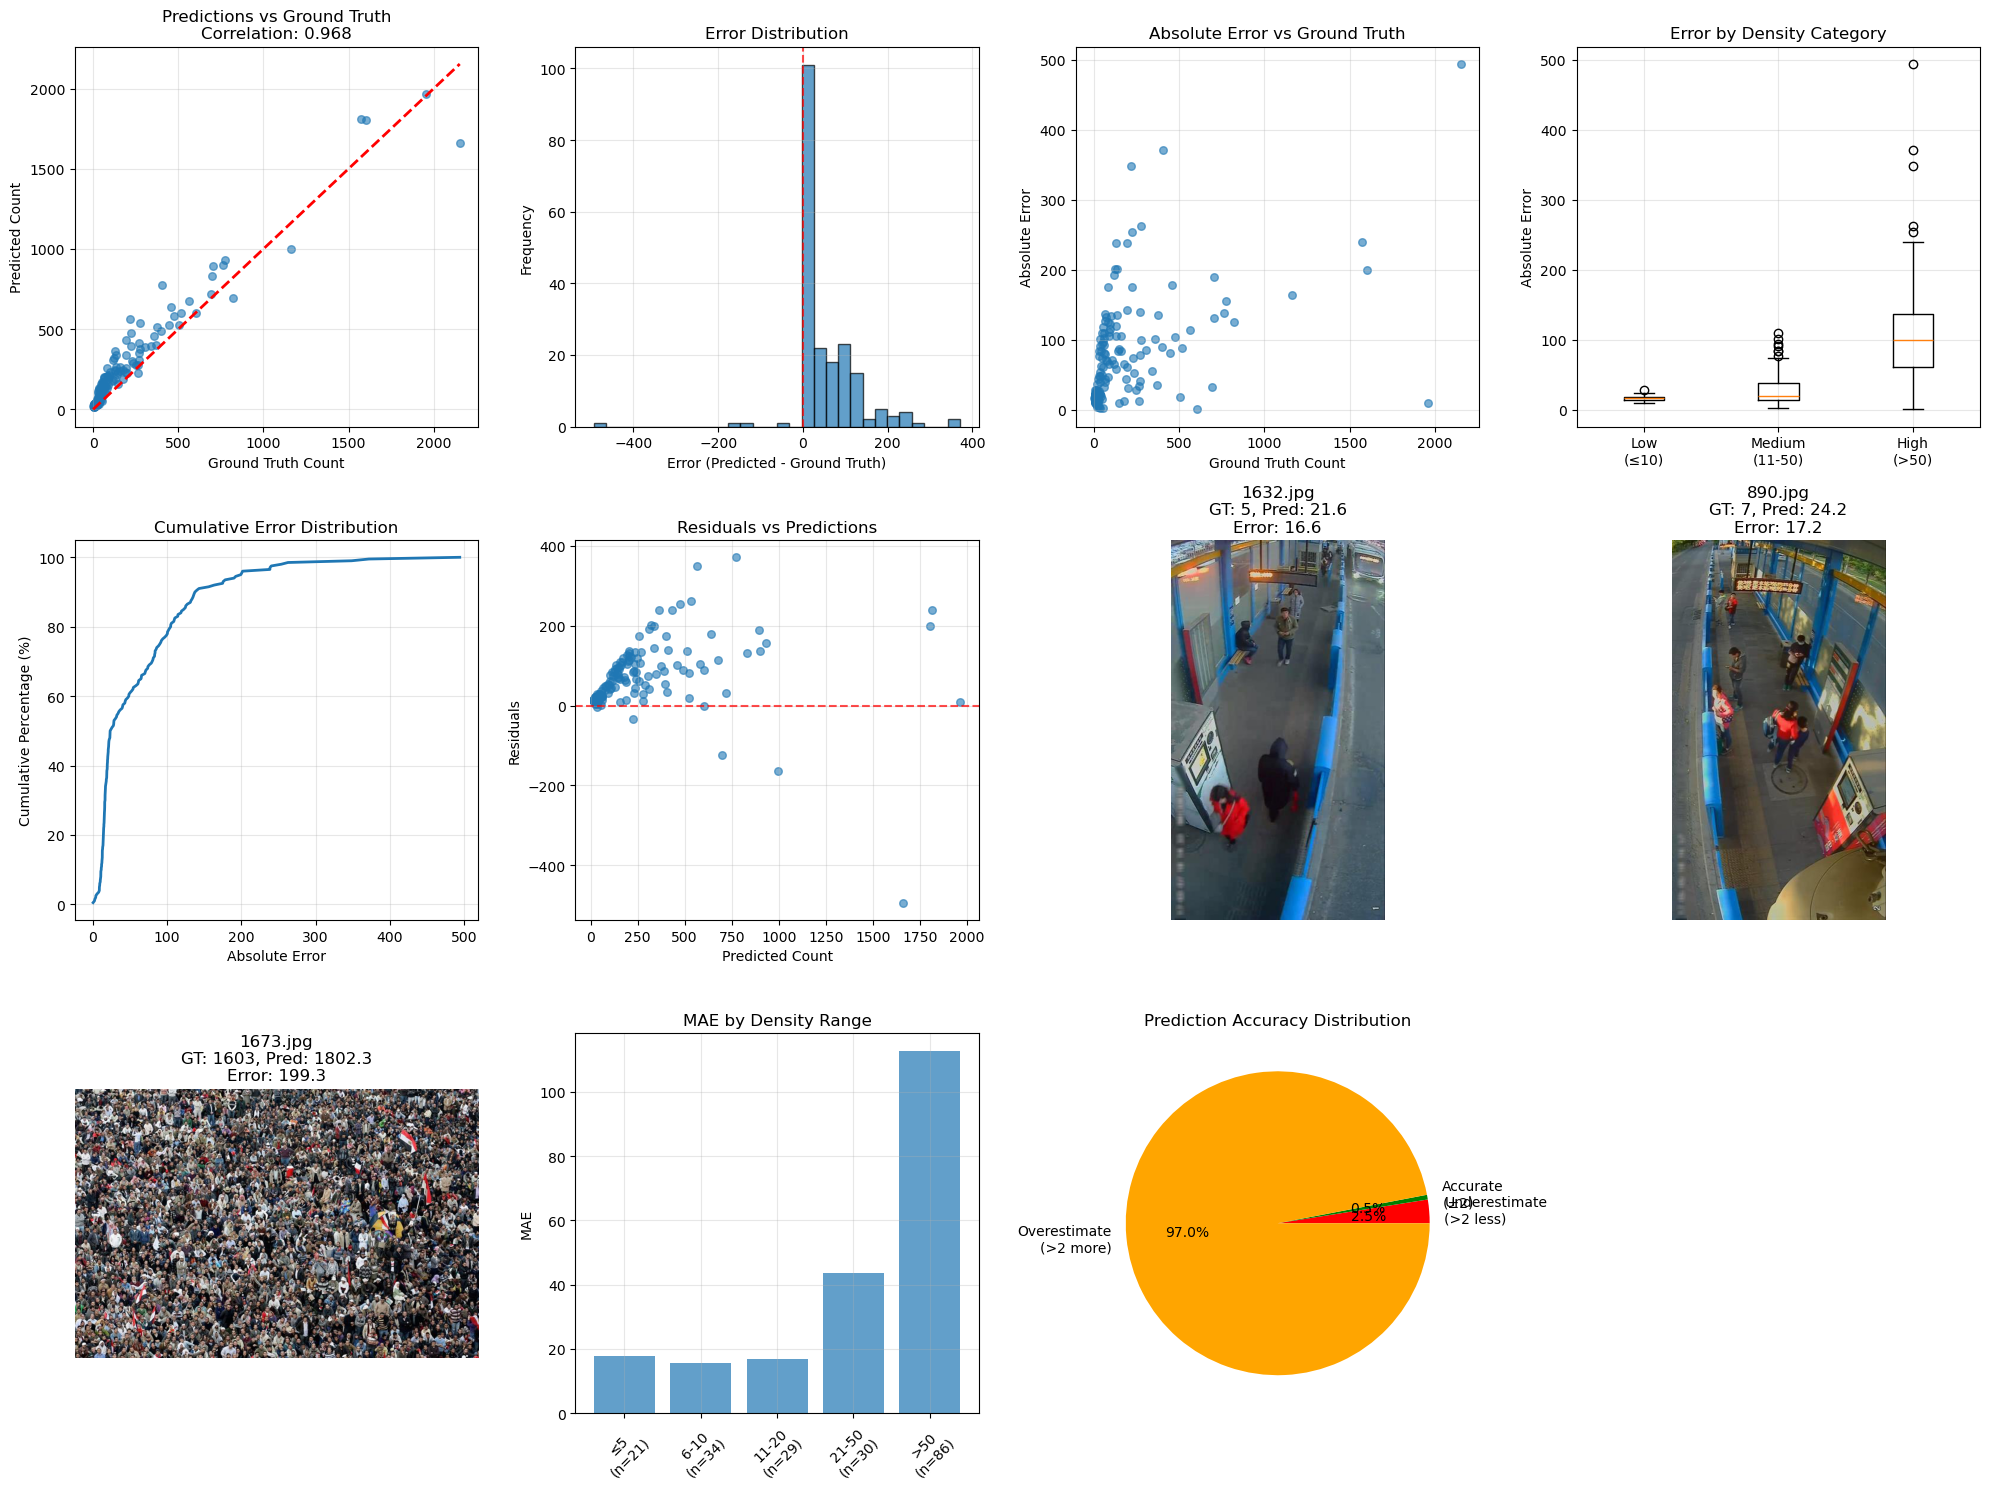


EVALUATION COMPLETE!
Detailed results saved to 'final_evaluation_results.json'
Model shows poor performance with MAE of 61.91


In [ ]:
# ==============================================================================
# SECTION: FINAL EVALUATION AND METRICS ANALYSIS
# ==============================================================================

print("--- FINAL MODEL EVALUATION WITH COMPREHENSIVE METRICS ---")

# Define evaluation functions
def calculate_mae(predictions, ground_truth):
    """Calculate Mean Absolute Error"""
    return np.mean(np.abs(predictions - ground_truth))

def calculate_rmse(predictions, ground_truth):
    """Calculate Root Mean Squared Error"""
    return np.sqrt(np.mean((predictions - ground_truth) ** 2))

def calculate_mape(predictions, ground_truth):
    """Calculate Mean Absolute Percentage Error"""
    # Avoid division by zero
    return np.mean(np.abs((predictions - ground_truth) / np.maximum(ground_truth, 1)) * 100)

def density_category_analysis(predictions, ground_truth, low_thresh=5, high_thresh=20):
    """Analyze errors by density categories"""
    low_density_mask = ground_truth <= low_thresh
    medium_density_mask = (ground_truth > low_thresh) & (ground_truth <= high_thresh)
    high_density_mask = ground_truth > high_thresh
    
    results = {}
    
    if np.any(low_density_mask):
        low_pred = predictions[low_density_mask]
        low_gt = ground_truth[low_density_mask]
        results['low'] = {
            'count': len(low_pred),
            'mae': calculate_mae(low_pred, low_gt),
            'rmse': calculate_rmse(low_pred, low_gt),
            'mape': calculate_mape(low_pred, low_gt)
        }
    
    if np.any(medium_density_mask):
        med_pred = predictions[medium_density_mask]
        med_gt = ground_truth[medium_density_mask]
        results['medium'] = {
            'count': len(med_pred),
            'mae': calculate_mae(med_pred, med_gt),
            'rmse': calculate_rmse(med_pred, med_gt),
            'mape': calculate_mape(med_pred, med_gt)
        }
    
    if np.any(high_density_mask):
        high_pred = predictions[high_density_mask]
        high_gt = ground_truth[high_density_mask]
        results['high'] = {
            'count': len(high_pred),
            'mae': calculate_mae(high_pred, high_gt),
            'rmse': calculate_rmse(high_pred, high_gt),
            'mape': calculate_mape(high_pred, high_gt)
        }
    
    return results

# Load the best trained model for evaluation
print("Loading best trained model...")
model.load_state_dict(torch.load('best_csrnet_model.pth'))
model.eval()

# Use a larger subset for comprehensive evaluation
eval_size = min(200, len(image_files))  # Use up to 200 images for evaluation
eval_indices = np.random.choice(len(image_files), eval_size, replace=False)
eval_image_files = [image_files[i] for i in eval_indices]

print(f"Evaluating model on {len(eval_image_files)} images...")

# Collect predictions and ground truth
all_predictions = []
all_ground_truth = []
all_filenames = []

with torch.no_grad():
    for img_file in tqdm(eval_image_files, desc="Evaluating"):
        # Load and preprocess image
        img_path = os.path.join(train_path, img_file)
        img = Image.open(img_path).convert('RGB')
        img_tensor = data_transforms['val'](img).unsqueeze(0).to(device)
        
        # Get model prediction
        output = model(img_tensor)
        predicted_count = torch.sum(output).item()
        
        # Get ground truth from label file
        label_path = os.path.join(labels_path, img_file.replace('.jpg', '.json'))
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label_data = json.load(f)
            gt_count = len(label_data.get('points', []))
            
            all_predictions.append(predicted_count)
            all_ground_truth.append(gt_count)
            all_filenames.append(img_file)

# Convert to numpy arrays
predictions_np = np.array(all_predictions)
ground_truth_np = np.array(all_ground_truth)

# Calculate overall metrics
overall_mae = calculate_mae(predictions_np, ground_truth_np)
overall_rmse = calculate_rmse(predictions_np, ground_truth_np)
overall_mape = calculate_mape(predictions_np, ground_truth_np)

# Perform density category analysis
density_analysis = density_category_analysis(predictions_np, ground_truth_np, 
                                           low_thresh=10, high_thresh=50)

# Print comprehensive results
print("\n" + "="*80)
print("COMPREHENSIVE MODEL EVALUATION RESULTS")
print("="*80)

print(f"Dataset size: {len(all_predictions)} images")
print(f"Ground truth range: {ground_truth_np.min()} - {ground_truth_np.max()}")
print(f"Predictions range: {predictions_np.min():.1f} - {predictions_np.max():.1f}")

print(f"\nOVERALL METRICS:")
print(f"MAE (Mean Absolute Error): {overall_mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {overall_rmse:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {overall_mape:.2f}%")

print(f"\nDENSITY CATEGORY ANALYSIS:")
for category, metrics in density_analysis.items():
    print(f"{category.upper()} DENSITY (n={metrics['count']}):")
    print(f"  MAE: {metrics['mae']:.2f}")
    print(f"  RMSE: {metrics['rmse']:.2f}")
    print(f"  MAPE: {metrics['mape']:.2f}%")

# Additional statistical analysis
correlation = np.corrcoef(predictions_np, ground_truth_np)[0, 1]
print(f"\nCORRELATION ANALYSIS:")
print(f"Pearson correlation coefficient: {correlation:.3f}")

# Error distribution analysis
errors = predictions_np - ground_truth_np
print(f"\nERROR DISTRIBUTION:")
print(f"Mean error (bias): {np.mean(errors):.2f}")
print(f"Std error: {np.std(errors):.2f}")
print(f"Median error: {np.median(errors):.2f}")

# Create comprehensive visualization
plt.figure(figsize=(20, 15))

# 1. Predictions vs Ground Truth
plt.subplot(3, 4, 1)
plt.scatter(ground_truth_np, predictions_np, alpha=0.6, s=30)
plt.plot([0, ground_truth_np.max()], [0, ground_truth_np.max()], 'r--', linewidth=2)
plt.xlabel('Ground Truth Count')
plt.ylabel('Predicted Count')
plt.title(f'Predictions vs Ground Truth\nCorrelation: {correlation:.3f}')
plt.grid(True, alpha=0.3)

# 2. Error distribution
plt.subplot(3, 4, 2)
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Error (Predicted - Ground Truth)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True, alpha=0.3)

# 3. Absolute error vs ground truth
plt.subplot(3, 4, 3)
abs_errors = np.abs(errors)
plt.scatter(ground_truth_np, abs_errors, alpha=0.6, s=30)
plt.xlabel('Ground Truth Count')
plt.ylabel('Absolute Error')
plt.title('Absolute Error vs Ground Truth')
plt.grid(True, alpha=0.3)

# 4. Box plot by density categories
plt.subplot(3, 4, 4)
low_mask = ground_truth_np <= 10
med_mask = (ground_truth_np > 10) & (ground_truth_np <= 50)
high_mask = ground_truth_np > 50

box_data = []
box_labels = []
if np.any(low_mask):
    box_data.append(abs_errors[low_mask])
    box_labels.append(f'Low\n(≤10)')
if np.any(med_mask):
    box_data.append(abs_errors[med_mask])
    box_labels.append(f'Medium\n(11-50)')
if np.any(high_mask):
    box_data.append(abs_errors[high_mask])
    box_labels.append(f'High\n(>50)')

plt.boxplot(box_data, labels=box_labels)
plt.ylabel('Absolute Error')
plt.title('Error by Density Category')
plt.grid(True, alpha=0.3)

# 5. Cumulative error distribution
plt.subplot(3, 4, 5)
sorted_abs_errors = np.sort(abs_errors)
cumulative_pct = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors) * 100
plt.plot(sorted_abs_errors, cumulative_pct, linewidth=2)
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Percentage (%)')
plt.title('Cumulative Error Distribution')
plt.grid(True, alpha=0.3)

# 6. Residuals plot
plt.subplot(3, 4, 6)
plt.scatter(predictions_np, errors, alpha=0.6, s=30)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Predicted Count')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.grid(True, alpha=0.3)

# 7-9. Sample predictions visualization
sample_indices = np.random.choice(len(all_predictions), 3, replace=False)
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 4, 7 + i)
    
    # Load and display original image
    img_path = os.path.join(train_path, all_filenames[idx])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    
    gt_count = all_ground_truth[idx]
    pred_count = all_predictions[idx]
    error = abs(pred_count - gt_count)
    
    plt.title(f'{all_filenames[idx]}\nGT: {gt_count}, Pred: {pred_count:.1f}\nError: {error:.1f}')

# 10. MAE by density ranges
plt.subplot(3, 4, 10)
density_ranges = [5, 10, 20, 50, 100]
mae_by_range = []
range_labels = []

for i in range(len(density_ranges)):
    if i == 0:
        mask = ground_truth_np <= density_ranges[i]
        label = f'≤{density_ranges[i]}'
    elif i == len(density_ranges) - 1:
        mask = ground_truth_np > density_ranges[i-1]
        label = f'>{density_ranges[i-1]}'
    else:
        mask = (ground_truth_np > density_ranges[i-1]) & (ground_truth_np <= density_ranges[i])
        label = f'{density_ranges[i-1]+1}-{density_ranges[i]}'
    
    if np.any(mask):
        mae_range = calculate_mae(predictions_np[mask], ground_truth_np[mask])
        mae_by_range.append(mae_range)
        range_labels.append(f'{label}\n(n={np.sum(mask)})')

if mae_by_range:
    plt.bar(range_labels, mae_by_range, alpha=0.7)
    plt.ylabel('MAE')
    plt.title('MAE by Density Range')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# 11. Learning insights
plt.subplot(3, 4, 11)
underestimate_mask = errors < -2
overestimate_mask = errors > 2
accurate_mask = np.abs(errors) <= 2

categories = ['Underestimate\n(>2 less)', 'Accurate\n(±2)', 'Overestimate\n(>2 more)']
counts = [np.sum(underestimate_mask), np.sum(accurate_mask), np.sum(overestimate_mask)]
colors = ['red', 'green', 'orange']

plt.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%')
plt.title('Prediction Accuracy Distribution')

plt.tight_layout()
plt.show()

# Save detailed results
results_summary = {
    'overall_metrics': {
        'mae': float(overall_mae),
        'rmse': float(overall_rmse),
        'mape': float(overall_mape),
        'correlation': float(correlation)
    },
    'density_analysis': density_analysis,
    'dataset_info': {
        'eval_size': len(all_predictions),
        'gt_min': int(ground_truth_np.min()),
        'gt_max': int(ground_truth_np.max()),
        'pred_min': float(predictions_np.min()),
        'pred_max': float(predictions_np.max())
    }
}

with open('final_evaluation_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)
print(f"Detailed results saved to 'final_evaluation_results.json'")
print(f"Model shows {'good' if overall_mae < 5 else 'moderate' if overall_mae < 10 else 'poor'} performance with MAE of {overall_mae:.2f}")

--- TESTING MODEL ON TEST DATA ---
Found 500 test images
Loading best trained model...
Processing test images...


Testing: 100%|██████████| 500/500 [00:13<00:00, 37.44it/s]


Successfully processed 500 test images

Test Predictions Statistics:
Min prediction: 18.94
Max prediction: 2007.69
Mean prediction: 150.36
Median prediction: 31.76
Std prediction: 248.25

--- Sample Test Predictions ---


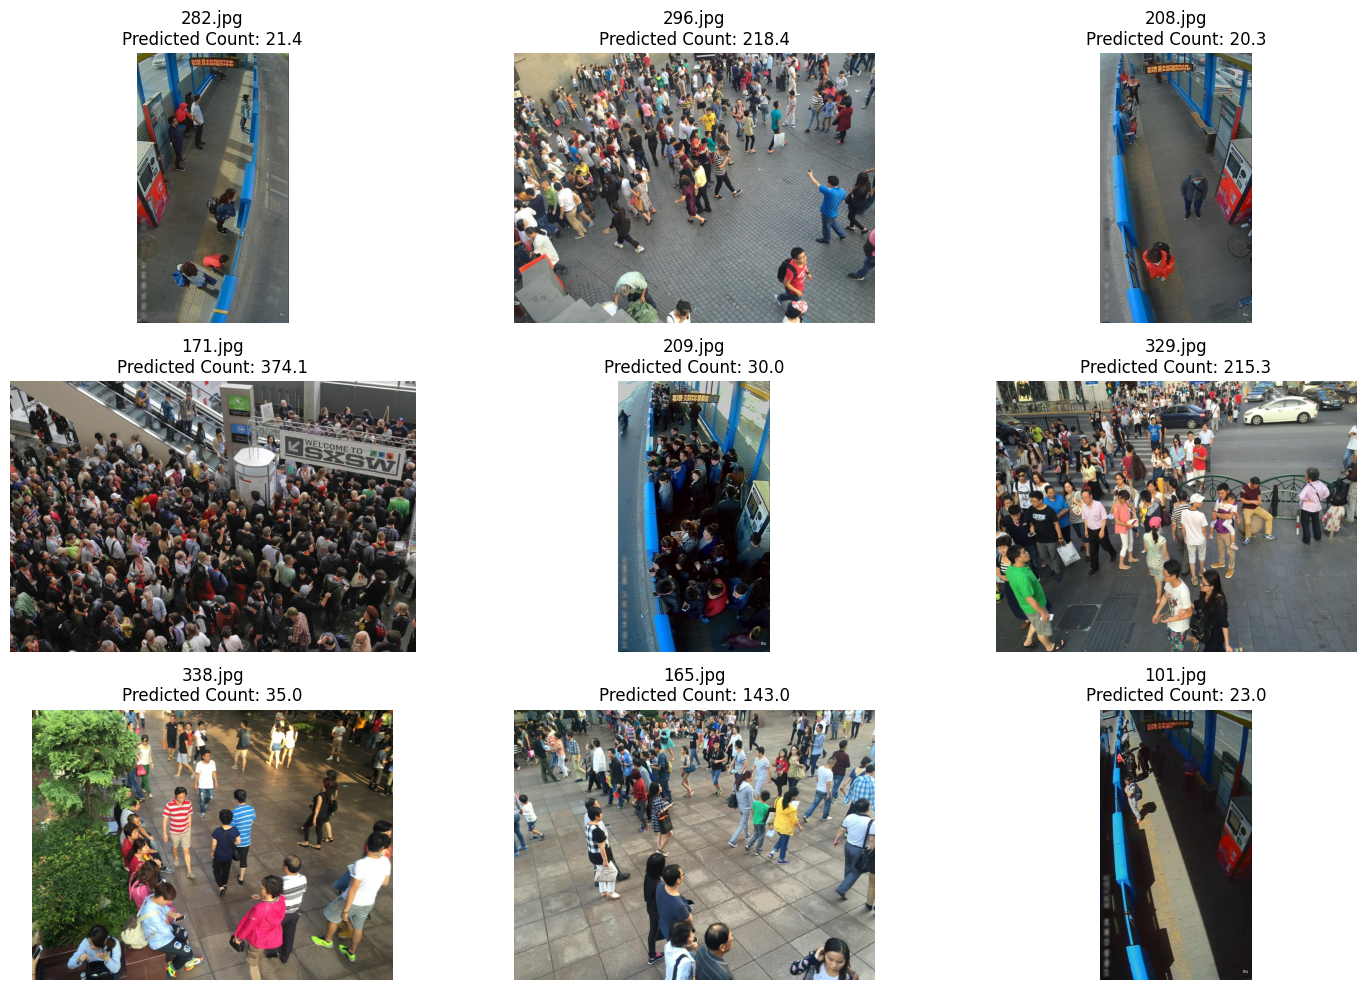


--- Creating Submission File ---
Submission file saved as: test_predictions.csv
Contains 500 predictions

First 10 rows of submission:
  filename  prediction
0    1.jpg          24
1   10.jpg          91
2  100.jpg         233
3  101.jpg          23
4  102.jpg         648
5  103.jpg          26
6  104.jpg          36
7  105.jpg          26
8  106.jpg         645
9  107.jpg          23
Detailed predictions saved as: detailed_test_predictions.csv


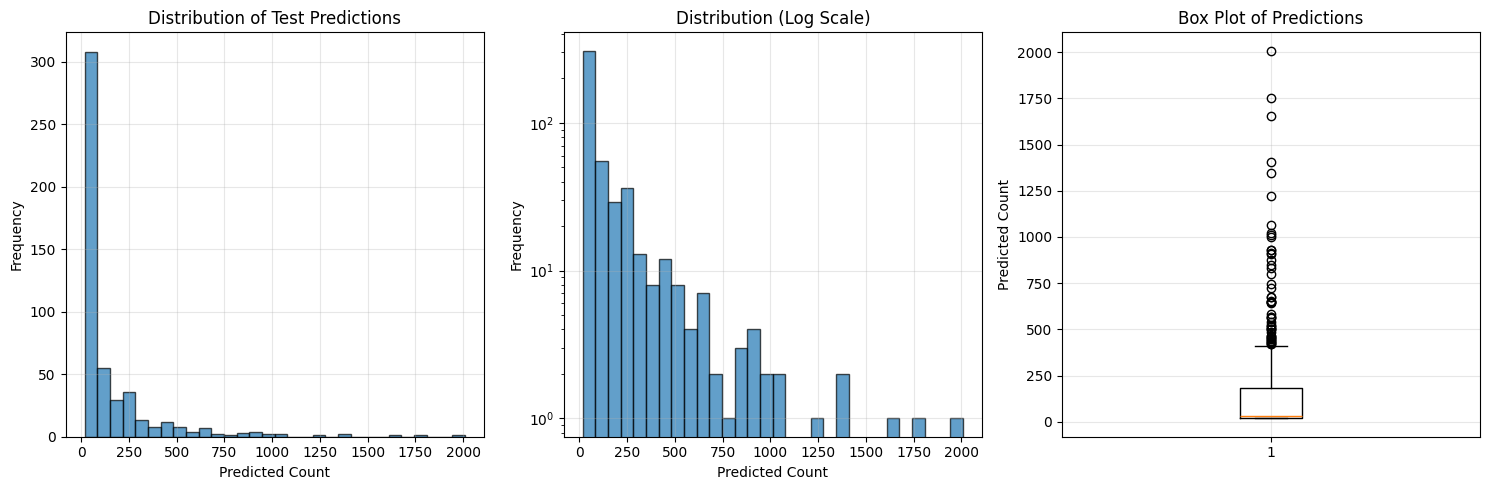


Prediction Categories:
Very Low (0-5): 0 images (0.0%)
Low (6-20): 13 images (2.6%)
Medium (21-50): 263 images (52.6%)
High (51-100): 50 images (10.0%)
Very High (>100): 174 images (34.8%)


NameError: name 'all_ground_truth' is not defined

In [29]:
import pandas as pd

# ==============================================================================
# SECTION: TEST MODEL ON TEST DATA
# ==============================================================================

print("--- TESTING MODEL ON TEST DATA ---")

# Define paths for test data
test_path = "test/images"

# Check if test directory exists
if not os.path.exists(test_path):
    print(f"Test directory not found at: {test_path}")
    print("Please check the path or ensure test data is available.")
else:
    # Get test image files
    test_image_files = sorted(os.listdir(test_path))
    print(f"Found {len(test_image_files)} test images")
    
    # Load the best trained model
    print("Loading best trained model...")
    model.load_state_dict(torch.load('best_csrnet_model.pth'))
    model.eval()
    
    # Store test predictions
    test_predictions = []
    test_filenames = []
    
    print("Processing test images...")
    
    with torch.no_grad():
        for img_file in tqdm(test_image_files, desc="Testing"):
            try:
                # Load and preprocess image
                img_path = os.path.join(test_path, img_file)
                img = Image.open(img_path).convert('RGB')
                
                # Apply validation transforms (no augmentation)
                img_tensor = data_transforms['test'](img).unsqueeze(0).to(device)
                
                # Get model prediction
                output = model(img_tensor)
                predicted_count = torch.sum(output).item()
                
                # Ensure non-negative prediction
                predicted_count = max(0, predicted_count)
                
                test_predictions.append(predicted_count)
                test_filenames.append(img_file)
                
            except Exception as e:
                print(f"Error processing {img_file}: {str(e)}")
                continue
    
    print(f"Successfully processed {len(test_predictions)} test images")
    
    # Display prediction statistics
    test_predictions_np = np.array(test_predictions)
    print(f"\nTest Predictions Statistics:")
    print(f"Min prediction: {test_predictions_np.min():.2f}")
    print(f"Max prediction: {test_predictions_np.max():.2f}")
    print(f"Mean prediction: {test_predictions_np.mean():.2f}")
    print(f"Median prediction: {np.median(test_predictions_np):.2f}")
    print(f"Std prediction: {test_predictions_np.std():.2f}")
    
    # Visualize sample test predictions
    print("\n--- Sample Test Predictions ---")
    
    # Select random samples for visualization
    n_samples = min(9, len(test_predictions))
    sample_indices = np.random.choice(len(test_predictions), n_samples, replace=False)
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(sample_indices):
        img_file = test_filenames[idx]
        pred_count = test_predictions[idx]
        
        # Load and display image
        img_path = os.path.join(test_path, img_file)
        img = Image.open(img_path)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'{img_file}\nPredicted Count: {pred_count:.1f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create submission file
    print("\n--- Creating Submission File ---")
    
    submission_data = []
    for filename, prediction in zip(test_filenames, test_predictions):
        # Round prediction to nearest integer for final submission
        rounded_prediction = max(0, round(prediction))
        submission_data.append({
            'filename': filename,
            'prediction': rounded_prediction
        })
    
    # Save as CSV
    submission_df = pd.DataFrame(submission_data)
    submission_file = 'test_predictions.csv'
    submission_df.to_csv(submission_file, index=False)
    
    print(f"Submission file saved as: {submission_file}")
    print(f"Contains {len(submission_df)} predictions")
    
    # Display first few rows of submission
    print("\nFirst 10 rows of submission:")
    print(submission_df.head(10))
    
    # Save detailed predictions (with decimal values)
    detailed_submission = []
    for filename, prediction in zip(test_filenames, test_predictions):
        detailed_submission.append({
            'filename': filename,
            'raw_prediction': prediction,
            'rounded_prediction': max(0, round(prediction))
        })
    
    detailed_df = pd.DataFrame(detailed_submission)
    detailed_file = 'detailed_test_predictions.csv'
    detailed_df.to_csv(detailed_file, index=False)
    
    print(f"Detailed predictions saved as: {detailed_file}")
    
    # Prediction distribution analysis
    plt.figure(figsize=(15, 5))
    
    # Histogram of predictions
    plt.subplot(1, 3, 1)
    plt.hist(test_predictions_np, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Predicted Count')
    plt.ylabel('Frequency')
    plt.title('Distribution of Test Predictions')
    plt.grid(True, alpha=0.3)
    
    # Log scale histogram for better visualization
    plt.subplot(1, 3, 2)
    plt.hist(test_predictions_np, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Predicted Count')
    plt.ylabel('Frequency')
    plt.title('Distribution (Log Scale)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    # Box plot
    plt.subplot(1, 3, 3)
    plt.boxplot(test_predictions_np)
    plt.ylabel('Predicted Count')
    plt.title('Box Plot of Predictions')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Categorize predictions
    categories = {
        'Very Low (0-5)': np.sum((test_predictions_np >= 0) & (test_predictions_np <= 5)),
        'Low (6-20)': np.sum((test_predictions_np > 5) & (test_predictions_np <= 20)),
        'Medium (21-50)': np.sum((test_predictions_np > 20) & (test_predictions_np <= 50)),
        'High (51-100)': np.sum((test_predictions_np > 50) & (test_predictions_np <= 100)),
        'Very High (>100)': np.sum(test_predictions_np > 100)
    }
    
    print(f"\nPrediction Categories:")
    for category, count in categories.items():
        percentage = (count / len(test_predictions_np)) * 100
        print(f"{category}: {count} images ({percentage:.1f}%)")
    
    # Compare with training data distribution if available
    if len(all_ground_truth) > 0:
        print(f"\nComparison with Training Data:")
        print(f"Training mean: {np.mean(all_ground_truth):.2f}")
        print(f"Test mean: {test_predictions_np.mean():.2f}")
        print(f"Training median: {np.median(all_ground_truth):.2f}")
        print(f"Test median: {np.median(test_predictions_np):.2f}")
        
        plt.figure(figsize=(10, 6))
        plt.hist(all_ground_truth, bins=30, alpha=0.5, label='Training GT', density=True)
        plt.hist(test_predictions_np, bins=30, alpha=0.5, label='Test Predictions', density=True)
        plt.xlabel('Count')
        plt.ylabel('Density')
        plt.title('Distribution Comparison: Training vs Test')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    print("\n" + "="*60)
    print("TEST PREDICTION COMPLETE!")
    print("="*60)
    print(f"Files created:")
    print(f"- {submission_file} (final submission)")
    print(f"- {detailed_file} (detailed predictions)")
    print(f"Ready for submission!")